In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

transform = transforms.Compose(
    [ 
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
     transforms.Normalize(mean, std)])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/pruning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/pruning


In [4]:
! git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

fatal: destination path 'PyTorch_CIFAR10' already exists and is not an empty directory.


In [4]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
%cd PyTorch_CIFAR10
! python train.py --download_weights 1
%cd ..

/content/drive/MyDrive/pruning/PyTorch_CIFAR10
100% 979M/979M [00:59<00:00, 16.6MMiB/s]
Download successful. Unzipping file...
Unzip file successful!
/content/drive/MyDrive/pruning


In [5]:
from PyTorch_CIFAR10.cifar10_models.resnet import resnet18

model = resnet18(pretrained=True).cuda()
model.eval();

0 : cat (proba =  0.981)
1 : dog (proba =  0.005)
2 : horse (proba =  0.002)
3 : deer (proba =  0.002)
4 : frog (proba =  0.002)


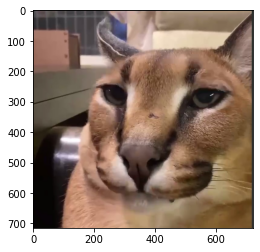

In [6]:

from PIL import Image
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

im = Image.open('./test_image.jpg')
plt.imshow(im)

transformed = transform(im).unsqueeze(0)
ranks = model(transformed.cuda())[0]
proba = softmax(ranks, dim = -1)
best_ranks_idxs = ranks.argsort(descending = True)[:5]
for i, index in enumerate(best_ranks_idxs):
    print(f'{i} : {classes[index.item()]} (proba = {proba[index.item()] : .3f})')

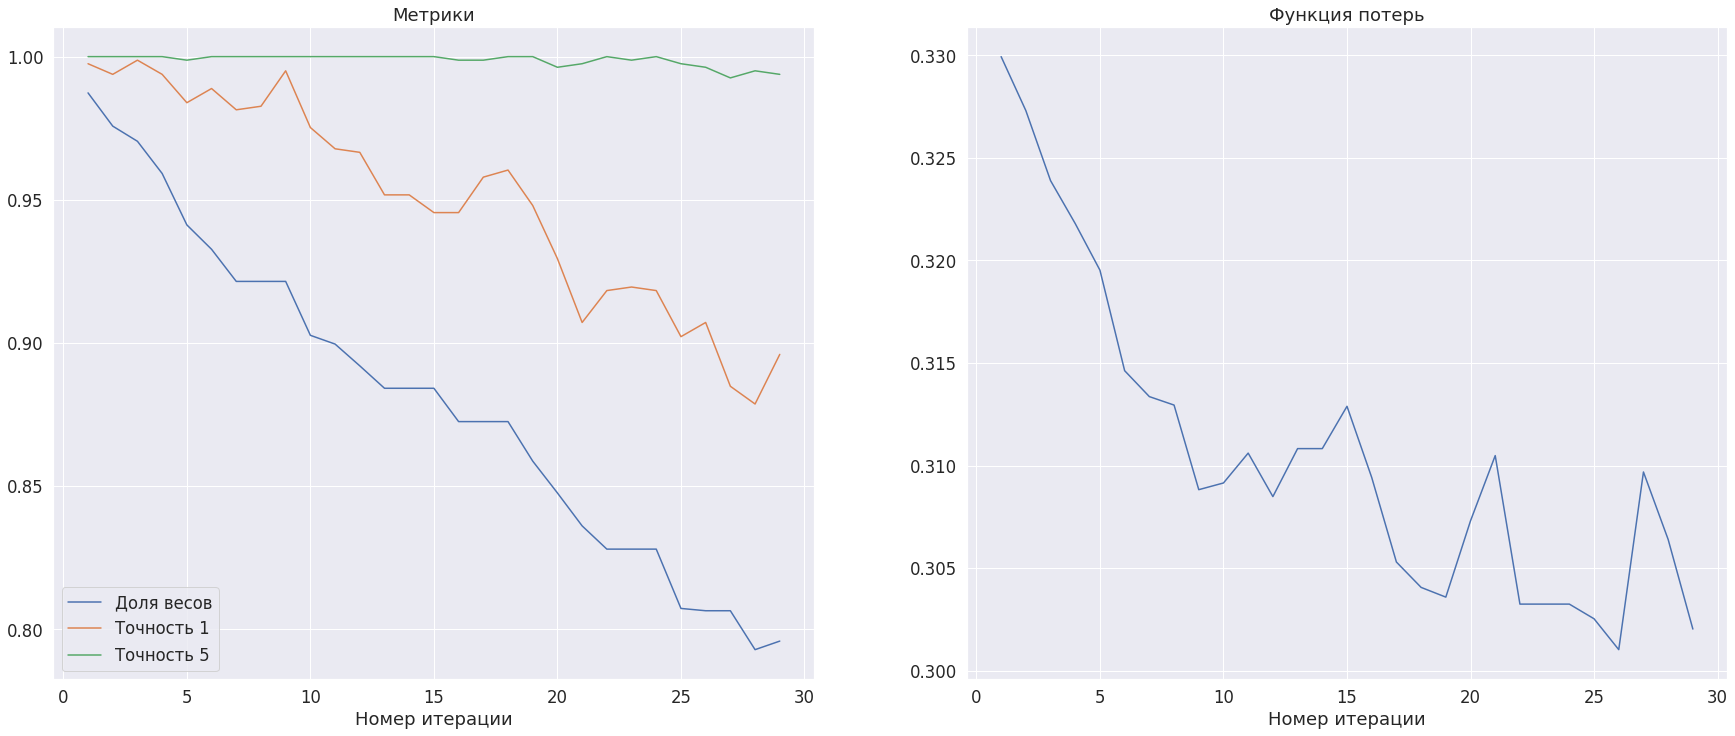

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
%load_ext autoreload
%autoreload 2

from utils import get_metrics
from genetic_algorithm import *

representation = CNNMaskPrune(model)
mutator = ConvGeneMutator(representation.fc_length, representation.conv_length,
                          0.15, 0.01)

l1, l2, l3 = 1, 1, 1
def fitness_func(metrics):
    weight_ratio, model_acc1, model_acc5 = metrics
    top1_errors = 1 - model_acc1
    top5_errors = 1 - model_acc5
    return (l1*weight_ratio + l2*top1_errors + l3*top5_errors) / (l1 + l2 + l3)

selector = FitnessSelector()
crossover = LossCrossover()


metrics = lambda model : get_metrics(model, trainloader, max_iter = 100)

mtl = MultiTargetLoss(representation, mutator, selector,
                      crossover, metrics, fitness_func)

сnn_pruned1 = mtl.prune(N = 15, selected_num = 5)

In [9]:
get_metrics(сnn_pruned1, testloader, max_iter = 100)

(0.7959271669387817, tensor(0.8342), tensor(0.9851))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/10 [00:00<?, ?it/s]

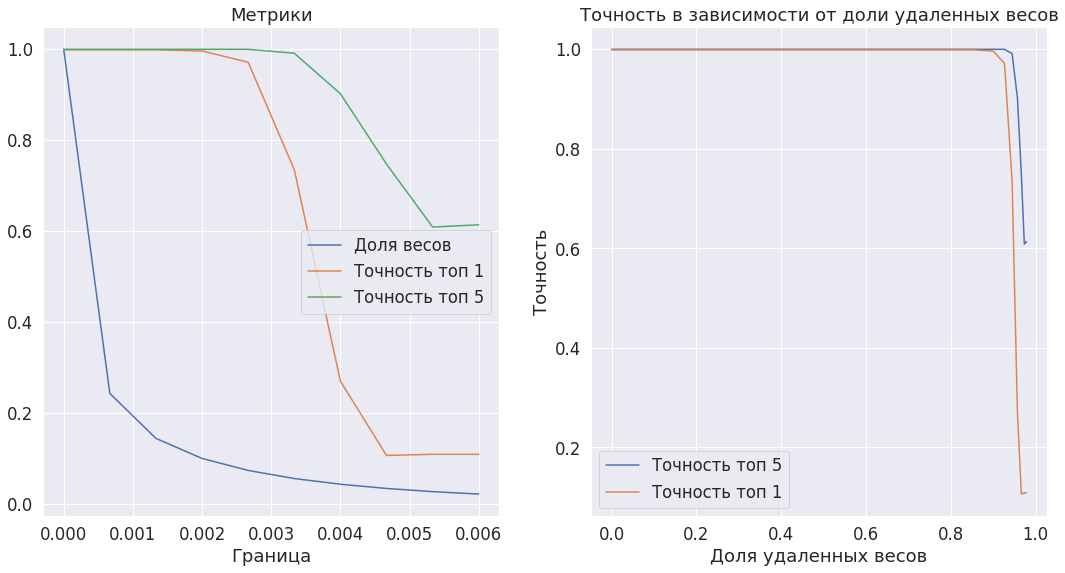

In [16]:
%load_ext autoreload
%autoreload 2
from utils import plot_threshold_pruning
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
plot_threshold_pruning(model, trainloader, np.linspace(0, 0.006, 10), 100)

In [19]:
from utils import threshold_prune
get_metrics(threshold_prune(model, 0.001), trainloader)

(0.1807262897491455, tensor(1.), tensor(1.))